In [42]:
import os
import numpy as np
import muspy
from tqdm import tqdm
import config
import utils
import tarfile
import shutil
import collections
from matplotlib import pyplot as plt

config_string = "standard"

ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
conf = config.Config(config_string, ROOT_PATH)



# Warning, ~ 10 hours required

In [ ]:
# lmd = utils.get_dataset("lmd", conf)
maestro = utils.get_dataset("maestro", conf)
nes = utils.get_dataset("nes", conf)
# hymn = get_dataset("hymn", conf)
folk = utils.get_dataset("folk", conf)

In [ ]:
print("folk: {}, maestro: {}, nes: {}, tot: {}".format(
    len(folk), 
    len(maestro), 
    len(nes), 
    len(folk)+len(maestro)+len(nes)))


---
## Data exploration

In [211]:
dataset = folk

In [212]:
# print(len(lmd[1]))
# print(np.unique(list(track.program for track in lmd[1].tracks)))
print(len(dataset))
flag = False
for i in tqdm(range(len(dataset))):

    # check if same instrument is used multiple times
    # if collections.Counter(np.unique(list(track.program for track in dataset[i].tracks)))  \
    #     != collections.Counter(list(track.program for track in dataset[i].tracks)):
    #     print(i)
    
    # check if there are key_signatures
    # if len(k_signs := dataset[i].key_signatures) > 1: 
    #     print(k_signs)
    #     print(i)

    # if len(t_signs := dataset[i].time_signatures) > 1: 
    #     print(t_signs)
    #     print(i)

    # if len(tempo := dataset[i].tempos) > 1: 
    #     print(tempo)
    #     print(i)

    # for track in dataset[i].tracks:
    #     if track.is_drum:
    #         print(i)
    pass

1033


100%|██████████| 1033/1033 [00:00<00:00, 513720.18it/s]


In [213]:
dataset[0].tracks[0].notes[0]

Note(time=0, pitch=76, duration=24, velocity=64)

In [214]:
stats = {
    "n_tracks" : np.zeros(1000),            # how many instruments are playing in a song (can also be 2 of the same instrument)
    "programs" : np.zeros(1000),             # which type of instrument
    "pitch": np.zeros(500),
    "velocity" : np.zeros(128),             # how loud (0-127)
    "durations": {},          # how many quarters does the note last(?)
    "drum_durations": {},
    "tempos": [],                           # how fast is the song in qpm (quarters per minute) --> can be non integer
    "time_signatures": {},                  # 4/4 or 3/4 etc... store it as a dict
    "key_signatures": {},        # which is the main key
}

for song in tqdm(dataset):

    resolution = song.resolution
    # how many tracks are in the song (tracks = different "instrument voices" but could be 4 pianos)
    stats["n_tracks"][len(song)] += 1 
    

    # how many different instruments and which
    programs = np.unique(list(track.program for track in song.tracks))  
    for program in programs:
        stats["programs"][program] += 1


    # stats on key signatures
    key_signatures = list(set((key_sign.root, key_sign.mode) for key_sign in song.key_signatures)) 

    for key_sign in key_signatures:
        if key_sign in stats["key_signatures"].keys():
            stats["key_signatures"][key_sign] += 1
        else:
            stats["key_signatures"][key_sign] = 1


    # stats on time_signatures --> need to know which exist / are used to create possible tokens
    time_signatures = list(set((time_sign.numerator, time_sign.denominator) for time_sign in song.time_signatures)) 

    for time_sign in time_signatures:
        if time_sign in stats["time_signatures"].keys():
            stats["time_signatures"][time_sign] += 1
        else:
            stats["time_signatures"][time_sign] = 1

    # stats on tempos
    tempos = list(set(tempo.qpm for tempo in song.tempos))

    for tempo in tempos:
        stats["tempos"].append(tempo)

    # notes
    for track in song.tracks:
        if len(track) > 0:
            stats["programs"][track.program] += 1

            if track.is_drum:
                for note in track.notes:

                    stats["pitch"][note.pitch + 128] += 1
                    stats["velocity"][note.velocity] += 1

                    if (dur := note.duration / resolution) in stats["drum_durations"].keys():
                        stats["drum_durations"][dur] += 1
                    else:
                        stats["drum_durations"][dur] = 1
            else:
                for note in track.notes:
                    stats["pitch"][note.pitch] += 1
                    stats["velocity"][note.velocity] += 1

                    if (dur := note.duration / resolution) in stats["durations"].keys():
                        stats["durations"][dur] += 1
                    else:
                        stats["durations"][dur] = 1

        


100%|██████████| 1033/1033 [00:01<00:00, 639.28it/s]


In [215]:
for i, n in enumerate(list(stats["n_tracks"])):
    if n>0:
        print("Number of song with {} tracks: {}".format(i,n))

Number of song with 1 tracks: 1032.0
Number of song with 4 tracks: 1.0


In [216]:
for i, n in enumerate(list(stats["programs"])):
    if n>0:
        print("Number of times program {} was used: {}".format(i,n))

Number of times program 0 was used: 2067.0


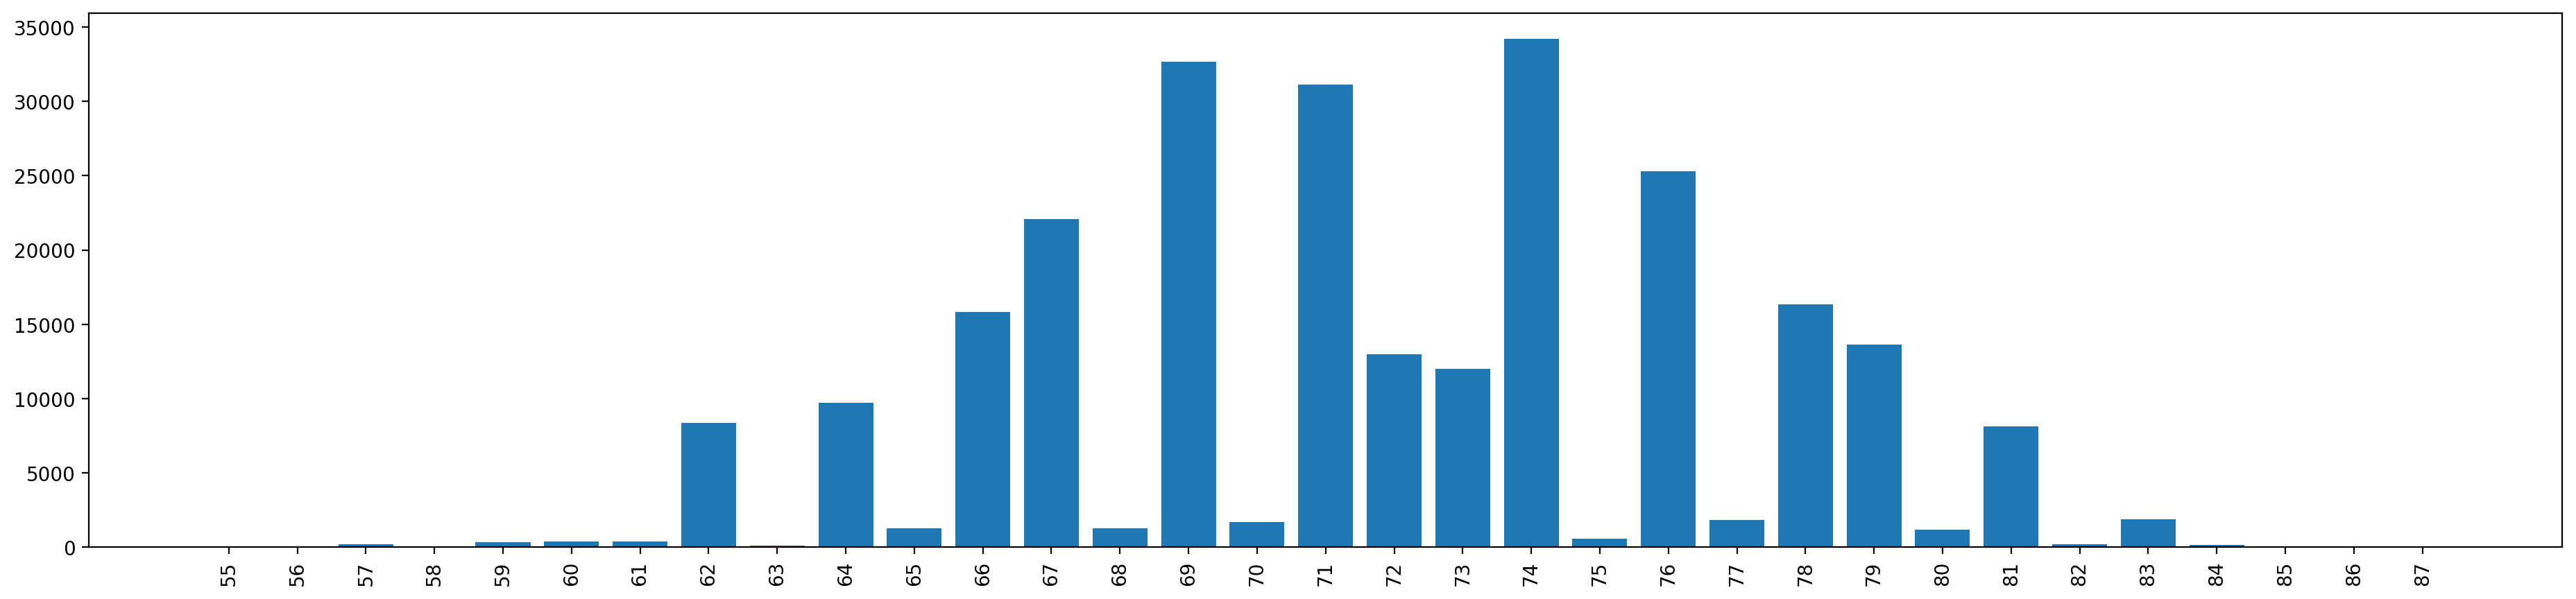

In [217]:
min_idx = len(stats["pitch"])
max_idx = 0
for i, n in enumerate(list(stats["pitch"])):
    if n>0:
        if i < min_idx:
            min_idx = i
        if i > max_idx:
            max_idx = i
plt.figure(figsize=(23,5))
plt.bar(range(len(stats["pitch"][min_idx:max_idx])), stats["pitch"][min_idx:max_idx])
plt.xticks(ticks=range(0,max_idx-min_idx), labels=range(min_idx, max_idx), rotation=90);

In [218]:
for i, n in enumerate(list(stats["velocity"])):
    if n>0:
        print("Number of times velocity {} was used: {}".format(i,n))

Number of times velocity 64 was used: 253873.0


In [219]:
tot = np.sum(list(stats["durations"].values()))
arr = np.zeros((len(stats["durations"].keys()), 2))
for i, key in enumerate(stats["durations"].keys()):
    arr[i,0] = key
    arr[i,1] =stats["durations"][key]/tot*100

arr = arr[arr[:,0].argsort()]

for i in arr:
    print("{:4.3f} beats, {:7.4f}%".format(i[0], i[1]))

0.125 beats,  0.1064%
0.167 beats,  0.1205%
0.250 beats,  2.4402%
0.333 beats,  2.0624%
0.375 beats,  0.0063%
0.500 beats, 67.5602%
0.667 beats,  0.0035%
0.750 beats,  0.4672%
1.000 beats, 22.0437%
1.250 beats,  0.0008%
1.333 beats,  0.0008%
1.500 beats,  2.2425%
1.750 beats,  0.0008%
2.000 beats,  2.1692%
2.500 beats,  0.2001%
3.000 beats,  0.3927%
3.500 beats,  0.0039%
4.000 beats,  0.1119%
4.250 beats,  0.0008%
4.500 beats,  0.0039%
5.000 beats,  0.0288%
6.000 beats,  0.0217%
7.000 beats,  0.0055%
8.000 beats,  0.0059%
9.000 beats,  0.0004%


In [225]:
tot = np.sum(list(stats["drum_durations"].values()))
print(tot)
arr = np.zeros((len(stats["drum_durations"].keys()), 2))
for i, key in enumerate(stats["drum_durations"].keys()):
    arr[i,0] = key
    arr[i,1] =stats["drum_durations"][key]/tot*100

arr = arr[arr[:,0].argsort()]

for i in arr:
    print("{:4.3f} beats, {:7.4f}%".format(i[0], i[1]))

0.0


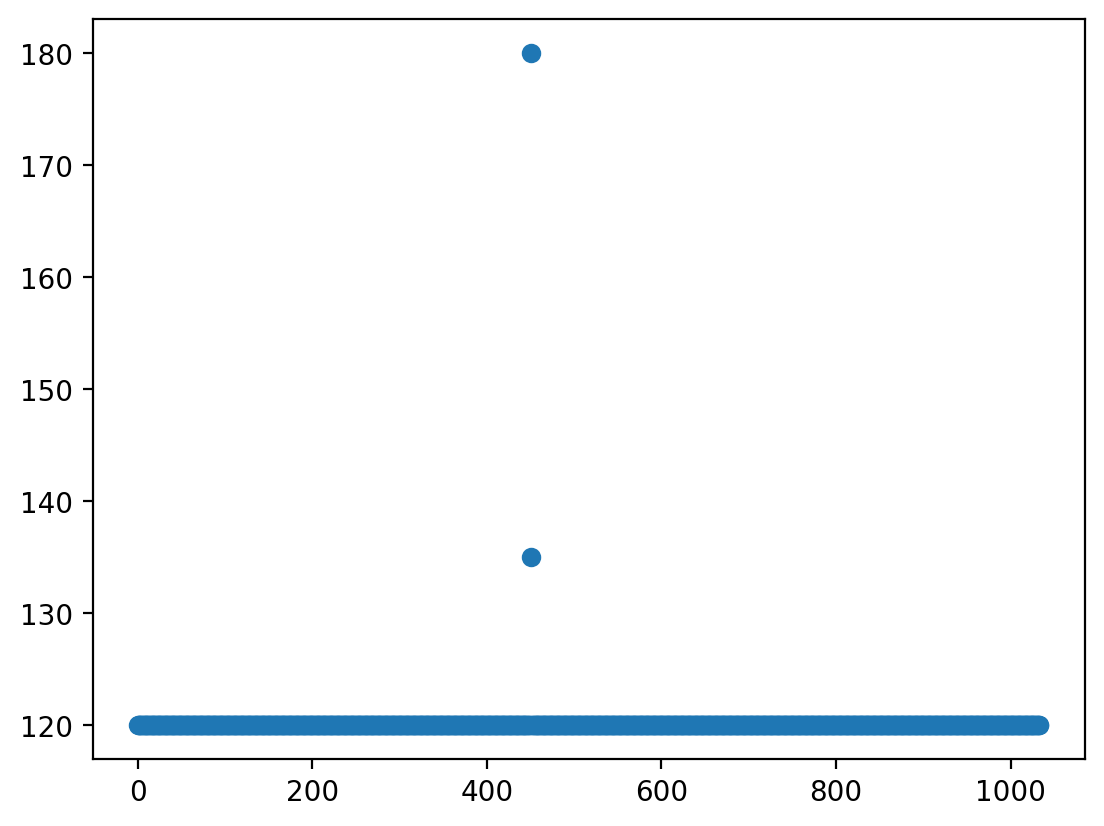

In [221]:
plt.scatter(range(len(stats["tempos"])), stats["tempos"]);

In [224]:
tot = np.sum(list(stats["key_signatures"].values()))
print(tot)
arr = np.zeros((len(stats["key_signatures"].keys()), 3))

for i, key in enumerate(stats["key_signatures"].keys()):
    arr[i,0] = stats["key_signatures"][key]/tot*100
    arr[i,1] = key[0]
    if key[1] == "major":
        arr[i,2] = 0
    else:
        arr[i,2] = 1

arr = arr[arr[:,0].argsort()]


for i in arr:
    print("{:5.2f}%, {:2.0f} {:.0f}".format(i[0], i[1], i[2]))

1072
 0.09%,  0 1
 0.09%, 11 0
 0.19%,  4 0
 0.28%, 11 1
 1.03%,  7 1
 1.21%, 10 0
 1.31%,  2 1
 2.43%,  5 0
 2.71%,  4 1
 3.73%,  9 1
 5.41%,  0 0
12.31%,  9 0
34.14%,  7 0
35.07%,  2 0


In [223]:
tot = np.sum(list(stats["time_signatures"].values()))
print(tot)
arr = np.zeros((len(stats["time_signatures"].keys()), 3))

for i, key in enumerate(stats["time_signatures"].keys()):
    arr[i,0] = stats["time_signatures"][key]/tot*100
    arr[i,1] = key[0]
    arr[i,2] = key[1]

arr = arr[arr[:,0].argsort()]


for i in arr:
    print("{:5.2f}%, {:.0f}/{:.0f}".format(i[0], i[1], i[2]))

1060
 0.19%, 6/4
 0.28%, 3/8
 0.28%, 1/4
 0.28%, 3/2
 0.28%, 1/16
 0.47%, 1/8
 0.66%, 2/2
 1.32%, 9/8
 4.15%, 2/4
 5.75%, 3/4
35.00%, 6/8
51.32%, 4/4
